## Bicycle Journeys: Exploratory Data Analysis

Start by importing pakages that will be used in all three tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Using pandas read_csv, the dataset is read into a dataframe. The data types that pandas has chosen are then discovered using dtypes

Some of the columns are the wrong data type so they are changed accordingly
* the start/end time columns are changed to datetime
* the start/end station columns are changed to object

In [2]:
df_metro = pd.read_csv('metro.csv')
df_metro.head()

C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\745810104.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro = pd.read_csv('metro.csv')


trip_id  duration        start_time          end_time  start_station  \
0  124657107         5  07/01/2019 00:04  07/01/2019 00:09           4312   
1  124657587         9  07/01/2019 00:07  07/01/2019 00:16           3066   
2  124658068         5  07/01/2019 00:20  07/01/2019 00:25           4410   
3  124659747        20  07/01/2019 00:44  07/01/2019 01:04           3045   
4  124660227        27  07/01/2019 00:44  07/01/2019 01:11           3035   

   start_lat   start_lon  end_station    end_lat     end_lon bike_id  \
0  34.066990 -118.290878         4410  34.063351 -118.296799    6168   
1  34.063389 -118.236160         3066  34.063389 -118.236160   17584   
2  34.063351 -118.296799         4312  34.066990 -118.290878   18920   
3  34.028511 -118.256668         4275  34.012520 -118.285896    6016   
4  34.048401 -118.260948         3049  34.056969 -118.253593    5867   

   plan_duration trip_route_category passholder_type bike_type  
0             30             One Way    Monthly Pass  standard  
1             30          Round Trip    Monthly Pass  electric  
2             30             One Way    Monthly Pass  electric  
3              1             One Way         Walk-up  standard  
4             30             One Way    Monthly Pass  standard

In [3]:
df_metro.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration            int64
trip_route_category     object
passholder_type         object
bike_type               object
dtype: object

In [4]:
df_metro['start_time'] = pd.to_datetime(df_metro['start_time'])
df_metro['end_time'] = pd.to_datetime(df_metro['end_time'])

df_metro['start_station'] = df_metro['start_station'].astype(object)
df_metro['end_station'] = df_metro['end_station'].astype(object)

To see summary statistics of the dataset before preprocessing, the describe function is used. 

To see the shape of the dataframe, shape is used.

There are 92124 samples and 15 features.

Some interesting initial findings are:
* the start_lat/lon and end_lat/lon columns have less rows than the other rows 
* the start_station and end_station means are different, inferring that people end their trips in different stations than where they start, on average

* the maximum trip length is 999 minutes which is 16.65 hours - could be an anomonly 
    * seems even more likely to be anomaly as 75% of the data is less than half an hour
* The minimum trip length is 1 minute, as well as 25% of the data, which also seems incorrect
    * This could be due to customers quickly putting their bike back as soon as they got, or technical errors

In [6]:
print(df_metro.shape)
df_metro.describe()

(92124, 15)


trip_id      duration     start_lat     start_lon       end_lat  \
count  9.212400e+04  92124.000000  89985.000000  89985.000000  88052.000000   
mean   1.274286e+08     33.168588     34.034786   -118.287893     34.034895   
std    1.524134e+06    129.057841      0.058803      0.073501      0.058790   
min    1.246571e+08      1.000000     33.710979   -118.495422     33.710979   
25%    1.261375e+08      6.000000     34.035801   -118.281181     34.037048   
50%    1.274911e+08     12.000000     34.046810   -118.258537     34.046810   
75%    1.287379e+08     22.000000     34.051941   -118.248253     34.051941   
max    1.303877e+08   1440.000000     34.177662   -118.231277     34.177662   

            end_lon  plan_duration  
count  88052.000000   92124.000000  
mean    -118.286699      60.290977  
std        0.072628     111.141364  
min     -118.495422       1.000000  
25%     -118.280952       1.000000  
50%     -118.258537      30.000000  
75%     -118.248253      30.000000  
max     -118.231277     999.000000

Trip_id isn't useful for analysis so the column is dropped

In [7]:
df_metro = df_metro.drop('trip_id', axis=1)

Next, I want to find out whether the dataset has duplicate rows and/or missing values.

We discover that there are no duplicates, however there are missing values in the start_lat/lon and end_lat/lon columns which explains the lower number of counts from above.

In [8]:
df_metro.duplicated().sum()

0

In [9]:
df_metro.isnull().sum()

duration                  0
start_time                0
end_time                  0
start_station             0
start_lat              2139
start_lon              2139
end_station               0
end_lat                4072
end_lon                4072
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
bike_type                 0
dtype: int64

There are a few thousand missing values. To deal with them I opted to fill in the values with the mode. 
* I didn't want to delete the rows because I want the most data I can get, but I didn't want to fill in with mean as the columns with missing values represent locations so I felt using the mode to fill in these was a good representation of an actual location

In [10]:
df_metro['start_lat'].fillna(df_metro['start_lat'].mode()[0], inplace=True)
df_metro['start_lon'].fillna(df_metro['start_lon'].mode()[0], inplace=True)
df_metro['end_lat'].fillna(df_metro['end_lat'].mode()[0], inplace=True)
df_metro['end_lon'].fillna(df_metro['end_lon'].mode()[0], inplace=True)

Next, I look to see what the unique values in columns with categories are and use bar charts to visualise the counts of these categories easily.

In [11]:
trips = df_metro['trip_route_category'].unique()
passholders = df_metro['passholder_type'].unique()
bikes = df_metro['bike_type'].unique()

print(f'Trip route type: {trips}')   
print(f'Passholder types: {passholders}')  
print(f'Bike types: {bikes}')     

Trip route type: ['One Way' 'Round Trip']
Passholder types: ['Monthly Pass' 'Walk-up' 'Annual Pass' 'One Day Pass' 'Flex Pass'
 'Testing']
Bike types: ['standard' 'electric' 'smart']


There are 2 trip routes - one way or round trip - and they have a large class imbalance. The one way trip has 76.7K entries, whereas a round trip only has 15.3k entries.

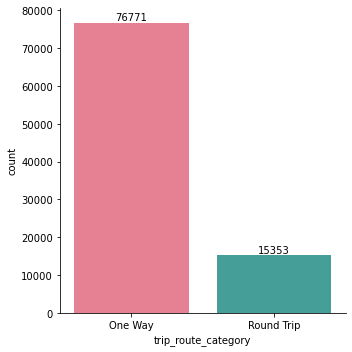

<Figure size 720x504 with 0 Axes>

In [12]:
trip_plot = sns.catplot(data= df_metro, x= 'trip_route_category', kind='count', palette="husl");
plt.figure(figsize=(10, 7))

for ax in trip_plot.axes.ravel():
    for n in ax.containers:
        labels = [f'{(v.get_height()):.0f}' for v in n]
        ax.bar_label(n, labels=labels, label_type='edge')

plt.show();

There are 6 types of passholders, the most popular one being the monthly pass with 57.1k, which is followed by walk-up passes at 23.5k.
The smallest category of passholders is the flex pass which has only 6 trips.

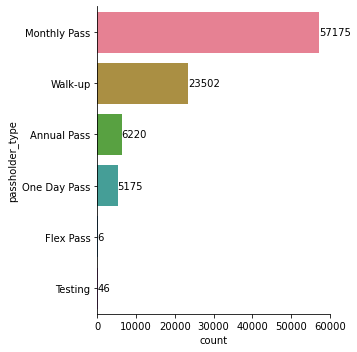

<Figure size 1080x504 with 0 Axes>

In [13]:
pass_plot = sns.catplot(data=df_metro, y='passholder_type', kind='count', palette="husl");
plt.figure(figsize=(15, 7))

for ax in pass_plot.axes.ravel():
    for n in ax.containers:
        labels = [f'{(v.get_width()):.0f}' for v in n]
        ax.bar_label(n, labels=labels)

plt.show()

The majority of bikes were electric (50.42%), followed by standard bikes with just under a third of trips, and finally smart bikes accounted for 17.59% of the trips.
The bike types are imbalanced as a result.

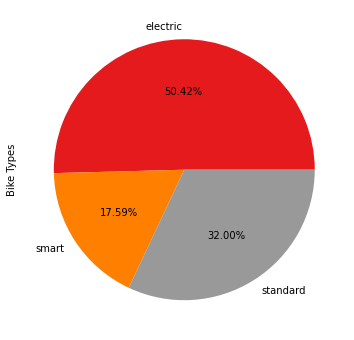

In [14]:
df_metro.groupby('bike_type').size().plot(kind='pie', autopct = lambda a:f'{a:.2f}%', ylabel="Bike Types", colormap="Set1", figsize=(6,6));

Now we find the mean duration of each passholder type in minutes.

The highest mean was for a one day pass which shows the average trip was 79 minutes.
The lowest mean was for flex pass which shows the average trip as 7 minutes.

This is probably because if you are paying for one day you want to make the most of the bike and are probably paying for a specific trip, but with a flex pass it implies a more flexible approach so you most likely paid for the bike for more than a day and don't have that level of committment as with a day pass.

In [15]:
df_metro.groupby(['passholder_type'])['duration'].mean()

passholder_type
Annual Pass     15.664148
Flex Pass        7.333333
Monthly Pass    15.854919
One Day Pass    79.548599
Testing         29.608696
Walk-up         69.722449
Name: duration, dtype: float64

Using crosstab, a table of passholder type by bike type was created, and subsequently used to create a barplot
* From the barplot we can see that most monthly passes come from people with electric bikes
* smart bikes have barely any annual pass holders, but the most one day passes
* standard bikes seems to have the most walk-up passes

In [17]:
pd.crosstab(df_metro['bike_type'], df_metro['passholder_type'])    #find counts of crosstabulation of bike type and passholder type

passholder_type  Annual Pass  Flex Pass  Monthly Pass  One Day Pass  Testing  \
bike_type                                                                      
electric                3467          2         35556          1047        0   
smart                    278          0          4656          3165       46   
standard                2475          4         16963           963        0   

passholder_type  Walk-up  
bike_type                 
electric            6374  
smart               8056  
standard            9072

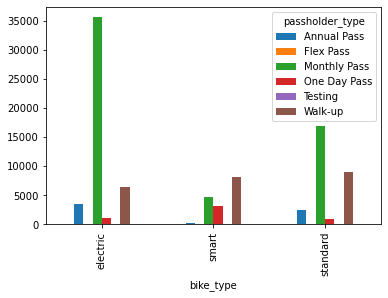

In [18]:
pd.crosstab(df_metro['bike_type'], df_metro['passholder_type']).plot.bar();

**Determining the shortest and longest trips and when they occur:**
* The longest trip being 1440 minutes seems like an outlier
* We can see this more clearly by plotting a histogram and see there are no trips near the 1440 trip
* The data is very positively skewed

In [19]:
low_dur = df_metro.duration.idxmin()
high_dur = df_metro.duration.idxmax()
low_anom = df_metro.duration.min()
high_anom = df_metro.duration.max()

print(f'The shortest trip duration is on {low_dur} with {low_anom} minutes, and the longest trip is on {high_dur} with {high_anom} minutes')

The shortest trip duration is on 83 with 1 minutes, and the longest trip is on 126 with 1440 minutes


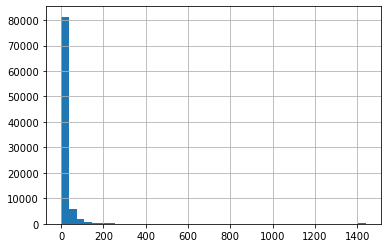

In [20]:
df_metro.duration.hist(bins=40);

I remove the rows where the duration is over 200, an estimate based off the barplot made
* this leaves us with all the trips less than 200 minutes (just over 3 hours)
* I chose 200 minutes after testing 600, 400 and 300 minutes and found the distributions were still extremely skewed
* I didn't want to go much below 200 minutes so not much data was lost and i thought some people may still have a trip for around 3 hours
* the graph is still very skewed but has more of a shape than previously

In [22]:
df_metro = df_metro[df_metro.duration < 200]

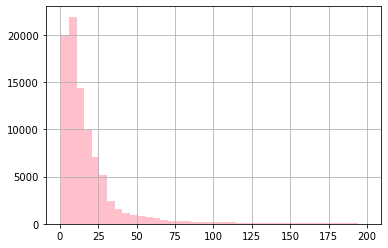

In [23]:
df_metro.duration.hist(color="pink", bins=40);

Looking at the distributions of the passholder types a few things stand out:
* Flex pass only has trips towards the 0 mark
* Testing pass is positively skewed but has what looks like an outlier near the 150 mark
* Walk-up trips look pretty evenly spread with a bit less density towards the 200 mark
     * This is similar for monthly pass and one day pass too
* The annual pass has a lot of samples where the duration is below around 20 minutes, then is scattered up to the 200 mark

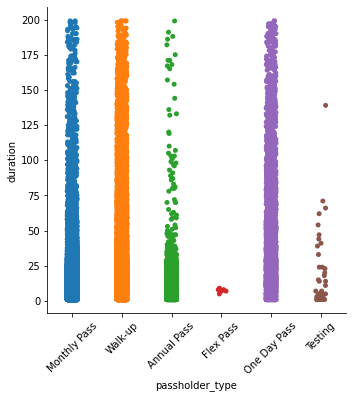

In [24]:
sns.catplot(x= 'passholder_type', y='duration', data=df_metro)
plt.xticks(rotation=45);

Next, we will look at how the duration of a journey changes betwen one way trips and round trips

We start by encoding the two categories, a one way trip becomes 0, and a round trip becomes 1

In [26]:
label = LabelEncoder()
df_metro['trip_route_category_enc'] = label.fit_transform(df_metro['trip_route_category'])
df_metro[['trip_route_category', 'trip_route_category_enc']]

C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\996509723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro['trip_route_category_enc'] = label.fit_transform(df_metro['trip_route_category'])


trip_route_category  trip_route_category_enc
0                 One Way                        0
1              Round Trip                        1
2                 One Way                        0
3                 One Way                        0
4                 One Way                        0
...                   ...                      ...
92119             One Way                        0
92120          Round Trip                        1
92121             One Way                        0
92122             One Way                        0
92123             One Way                        0

[90392 rows x 2 columns]

Next, a kde plot is made showing the distribution of both kinds of trips against each other

* We see that one way trips has a lower standard deviation (less spread out) and round trips are slightly more spread out 
* Round trips peaks slightly sooner than one way trips at around 0, but then has a second lower peak at around 25 minutes.

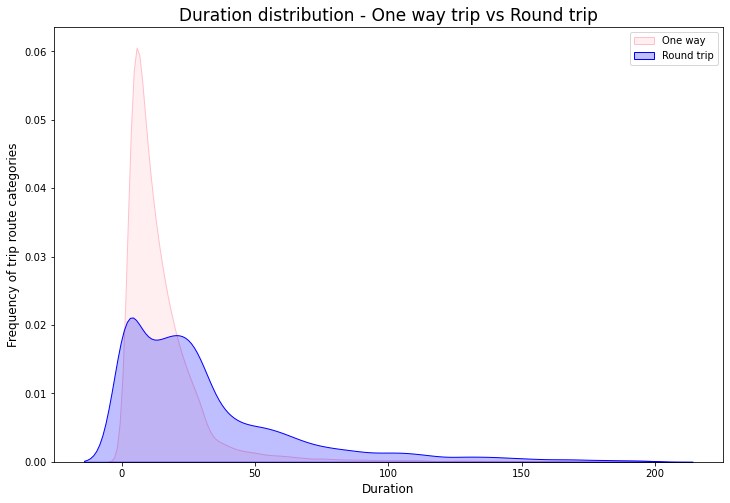

In [27]:
fig = plt.figure(figsize=(12, 8))
ax = sns.kdeplot(df_metro.loc[(df_metro['trip_route_category_enc'] == 0), 'duration'],
                 color='pink', shade=True, label='One way')
ax = sns.kdeplot(df_metro.loc[(df_metro['trip_route_category_enc'] == 1), 'duration'],
                 color='blue', shade=True, label='Round trip')
plt.title('Duration distribution - One way trip vs Round trip', fontsize=17)
plt.ylabel('Frequency of trip route categories', fontsize=12)
plt.xlabel('Duration', fontsize=12)
plt.legend();

Now we will look at some time series analysis.
* To start, I split the time column into year, month, day of week and hour and append each to the end of the dataframe

In [28]:
df_metro['year'] = df_metro['start_time'].dt.year
df_metro['month'] = df_metro['start_time'].dt.month
df_metro['day'] = df_metro['start_time'].dt.day
df_metro['day_of_week'] = df_metro['start_time'].dt.dayofweek
df_metro['hour'] = df_metro['start_time'].dt.hour

C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\2915868742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro['year'] = df_metro['start_time'].dt.year
C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\2915868742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro['month'] = df_metro['start_time'].dt.month
C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\2915868742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

By grouping the number of rides by the day of the week they start on we see that Saturdays have the least number of rides and Tuesday have the most number of rides

In [29]:
df_metro.groupby(['day_of_week']).agg(number_of_rides=('trip_route_category', 'count'))

number_of_rides
day_of_week                 
0                      13698
1                      14077
2                      13374
3                      13667
4                      13578
5                      10896
6                      11102

<AxesSubplot:xlabel='day_of_week'>

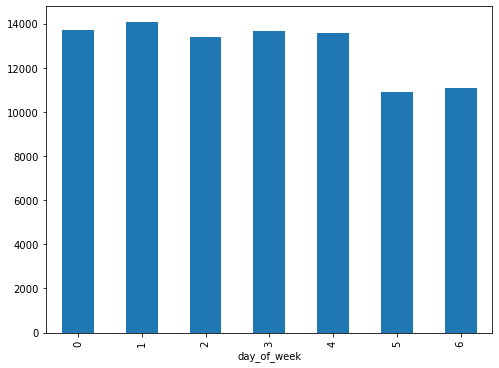

In [30]:
df_metro.groupby(['day_of_week'])['duration'].count().plot.bar(figsize = (8, 6))

In a similar way we can look at the number of trips but using their starting hour instead

We see that, as you would expect, there are very few trips at night especially between 1 and 5 am, and most trips start in the 17th hour which makes sense as people will probably use the bikes to go home after work.

<AxesSubplot:xlabel='hour'>

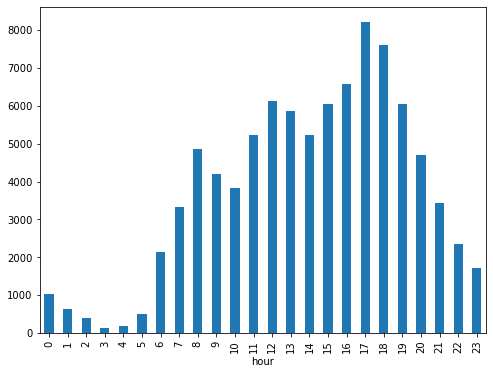

In [31]:
df_metro.groupby(['hour'])['duration'].count().plot.bar(figsize = (8, 6))

The below histogram shows us that there is an increase in bike rides up until around the third week of august (which is peak of summer so makes sense as more people will be out in the sun), then there appears to be a steady decrease in rides from there but would need a longer period of data to see if this relationship with the seasons is true.

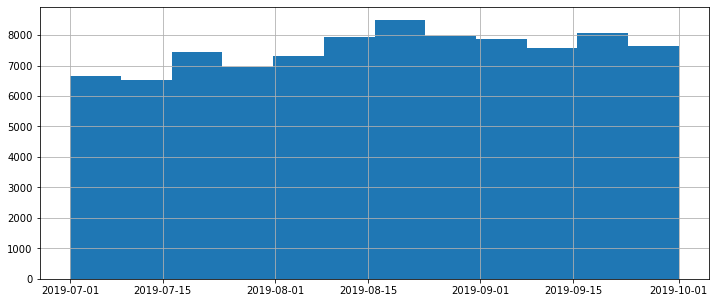

In [33]:
df_metro['start_time'].hist(figsize=(12,5), bins=12);

Next, I want to look at the distance travelled for the trips
* to find the distance between two geo coordinates, the haversine distance formula will need to be used (https://en.wikipedia.org/wiki/Haversine_formula)
* I opt for a formula that calculates row by row of a dataframe (idea from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas)
* I will use an estimate for the radius of earth at 6378 km (https://imagine.gsfc.nasa.gov/features/cosmic/earth_info.html)

In [34]:
def haversine_distance(geo):
    dlon = np.radians(geo[2]) - np.radians(geo[0])
    dlat = np.radians(geo[3]) - np.radians(geo[1]) 
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(geo[1])) * np.cos(np.radians(geo[3])) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6378 * c

In [35]:
df_metro['distance'] = df_metro[['start_lon', 'start_lat', 'end_lon', 'end_lat']].apply(haversine_distance, axis=1)

C:\Users\sinea\AppData\Local\Temp\ipykernel_21144\4000508015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro['distance'] = df_metro[['start_lon', 'start_lat', 'end_lon', 'end_lat']].apply(haversine_distance, axis=1)


If we plot distance against duration the resultant graphs gradient will show the speed. Average speed seems to be around 1km/5mins (very rough estimate taken off graph)

C:\Users\sinea\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


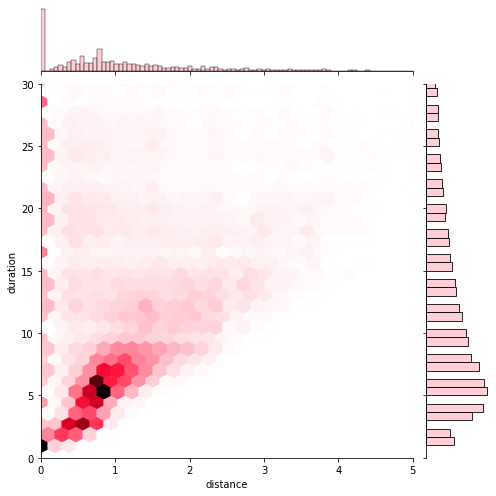

In [36]:
sns.jointplot(x=df_metro['distance'],
              y=df_metro['duration'], kind='hex', size = 7, color='pink', 
              joint_kws=dict(gridsize=200), xlim=(0, 5), ylim=(0, 30));

The summary statistics of the distance show us that the maximum journey lenght was 37.6km, and the mean is 1.8km. This is inline with the statistics of the duration of journeys where most were very short but few journeys were long. It has the same skew.

In [37]:
df_metro['distance'].describe()

count    90392.000000
mean         1.852998
std          3.732385
min          0.000000
25%          0.445607
50%          0.900228
75%          1.751646
max         37.649388
Name: distance, dtype: float64